In [795]:
# 이진 분류 문제 하나 정해서


# 그리드 ,랜더마이즈 서치 함수 정의
# DT
# KNN
# 교차검증
# 랜덤 포레스트
# AdaBoost
# XGBoost

# 딥러닝
# 단층 신경망
# 다층 신경망 - drop out 및 옵티 마이저, 역전파

# Accuracy, 및 precision, Recall
# Auc - Roc 커브

|지도 학습|출력 층 노드 수|출력 층 활성화 함수|비용 함수|
|---|---|---|---|
|이진 분류|1개|시그 모이드|교차 엔트로피 (CEE)|
|다중 분류|범주의 수|소프트 맥스|교차 엔트로피 (CEE)|
|회귀|1개|항등 함수|오차 제곱 (MSE)|

In [796]:
# lung cancer 분류 문제

In [797]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam # adam 의 러닝레이트를 바꾸기 위해서는
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report

import missingno as msno

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [798]:
data_set = pd.read_csv("../data/lung_cancer_data.csv", index_col=0)
print(data_set.head(1))

             Age Gender Smoking_History  Tumor_Size_mm Tumor_Location  \
Patient_ID                                                              
Patient0000   68   Male  Current Smoker      81.678677     Lower Lobe   

                 Stage Treatment  Survival_Months Ethnicity Insurance_Type  \
Patient_ID                                                                   
Patient0000  Stage III   Surgery               44  Hispanic       Medicare   

             ... Alanine_Aminotransferase_Level  \
Patient_ID   ...                                  
Patient0000  ...                      27.985571   

            Aspartate_Aminotransferase_Level Creatinine_Level   LDH_Level  \
Patient_ID                                                                  
Patient0000                        46.801214         1.245849  239.240255   

            Calcium_Level Phosphorus_Level Glucose_Level Potassium_Level  \
Patient_ID                                                                 
Patient

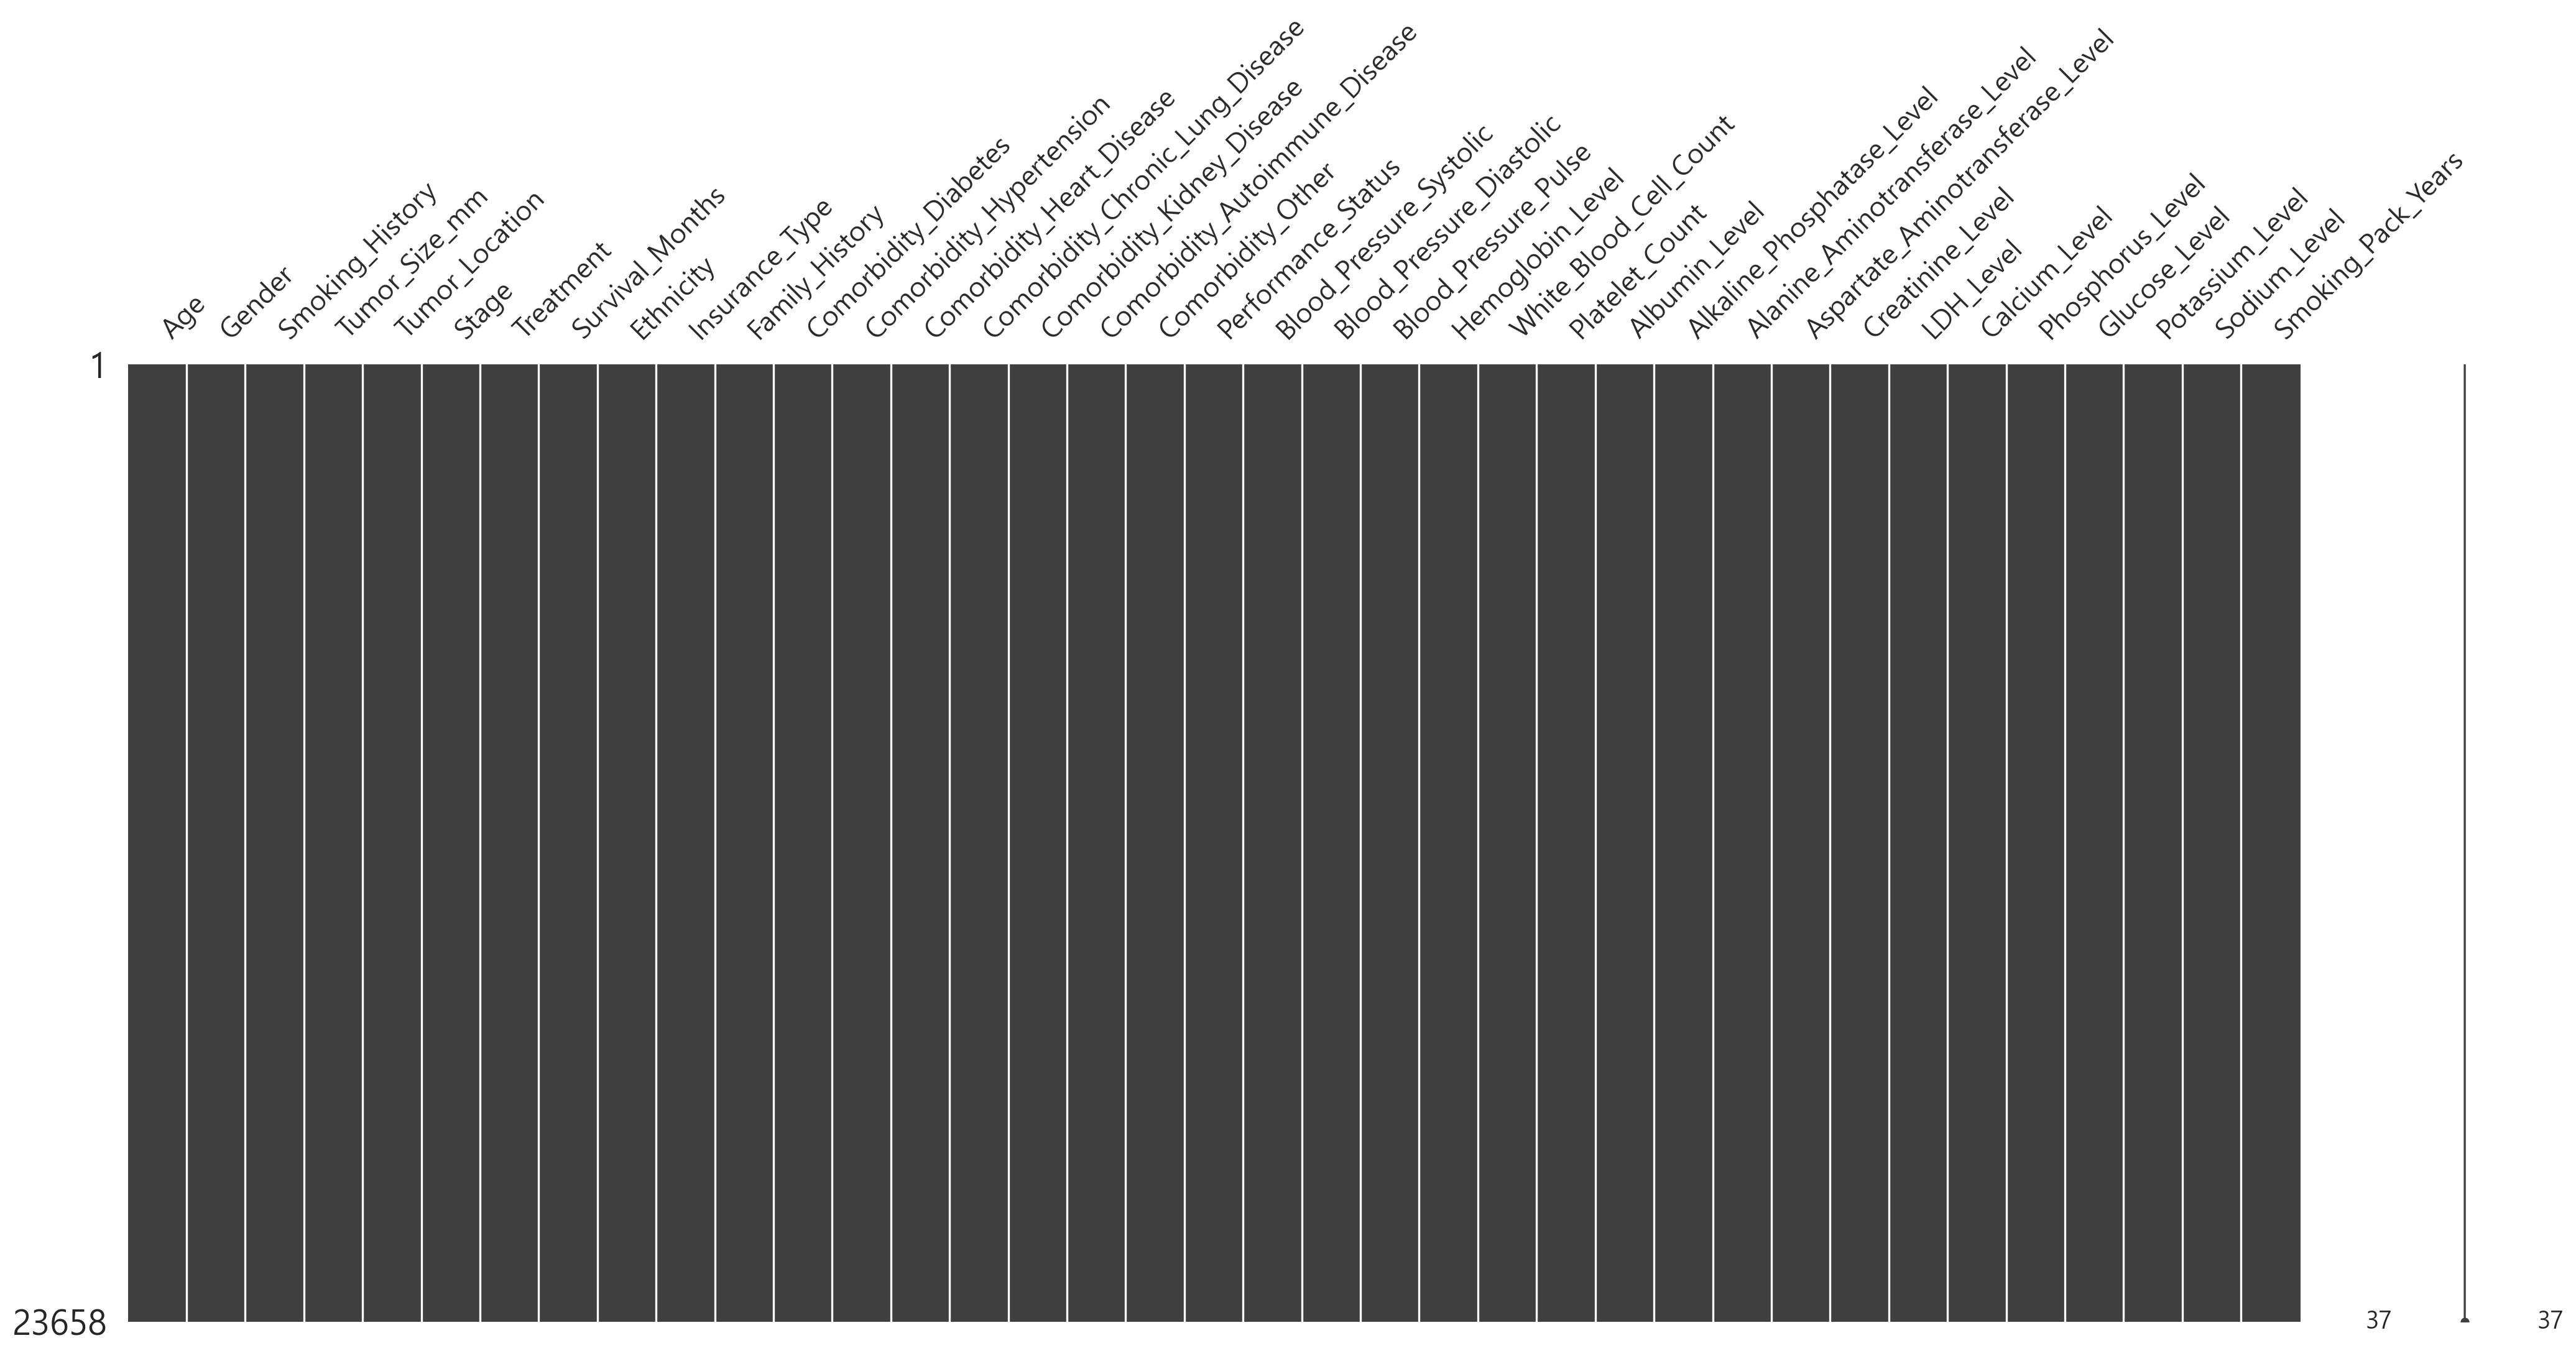

In [799]:
# 결측 확인
msno.matrix(data_set); # 결측이 없다.

In [800]:
data_set["Smoking_History"].unique() # 빈도수
data_set["Stage"].unique() # ordinal categorical
data_set["Gender"].unique() # categorical
data_set["Tumor_Location"].unique() # categorical
data_set["Treatment"].unique() # Leakage
data_set["Survival_Months"].unique() # Leakage
data_set["Ethnicity"].value_counts() # categorical - other 가 너무 많다..

Caucasian           4765
Hispanic            4761
African American    4737
Asian               4734
Other               4661
Name: Ethnicity, dtype: int64

In [801]:
gender = pd.get_dummies(data_set["Gender"], drop_first=True)

# 흡연 빈도수 맵핑해서 ordianl 로 변환
mapping = {"Never Smoked":0,"Former Smoker":1,"Current Smoker":2}
smoking = data_set["Smoking_History"].map(mapping)

# 흡연 빈도수 맵핑해서 ordianl 로 변환 stage ordinal
stage_ = {"Stage I":0,"Stage II":0,"Stage III":1,"Stage IV":1}
stage = data_set["Stage"].map(stage_)
# 암 위치
location = pd.get_dummies(data_set["Tumor_Location"], drop_first=True) # categorical
# 
# yes no 컬럼 카테고리화
binary_cats = ['Family_History', 'Comorbidity_Diabetes', 'Comorbidity_Hypertension',
       'Comorbidity_Heart_Disease', 'Comorbidity_Chronic_Lung_Disease',
       'Comorbidity_Kidney_Disease', 'Comorbidity_Autoimmune_Disease',
       'Comorbidity_Other']
binary_ = pd.get_dummies(data_set[binary_cats], drop_first=True)
# 
# 최종 컬럼
cols_to_train = ['Age', 'Tumor_Size_mm',
                 'Performance_Status', 'Blood_Pressure_Systolic',
                 'Blood_Pressure_Diastolic', 'Blood_Pressure_Pulse', 'Hemoglobin_Level',
                 'White_Blood_Cell_Count', 'Platelet_Count', 'Albumin_Level',
                 'Alkaline_Phosphatase_Level', 'Alanine_Aminotransferase_Level',
                 'Aspartate_Aminotransferase_Level', 'Creatinine_Level', 'LDH_Level',
                 'Calcium_Level', 'Phosphorus_Level', 'Glucose_Level', 'Potassium_Level',
                 'Sodium_Level', 'Smoking_Pack_Years']
# 
fianl_df = data_set[cols_to_train].copy()
fianl_df = pd.concat([fianl_df,binary_], axis=1)
fianl_df = pd.concat([fianl_df,location], axis=1)
fianl_df["smoke_frq"] = smoking
fianl_df["stage"] = stage
fianl_df["gender"] = gender

In [802]:
fianl_df.keys()

Index(['Age', 'Tumor_Size_mm', 'Performance_Status', 'Blood_Pressure_Systolic',
       'Blood_Pressure_Diastolic', 'Blood_Pressure_Pulse', 'Hemoglobin_Level',
       'White_Blood_Cell_Count', 'Platelet_Count', 'Albumin_Level',
       'Alkaline_Phosphatase_Level', 'Alanine_Aminotransferase_Level',
       'Aspartate_Aminotransferase_Level', 'Creatinine_Level', 'LDH_Level',
       'Calcium_Level', 'Phosphorus_Level', 'Glucose_Level', 'Potassium_Level',
       'Sodium_Level', 'Smoking_Pack_Years', 'Family_History_Yes',
       'Comorbidity_Diabetes_Yes', 'Comorbidity_Hypertension_Yes',
       'Comorbidity_Heart_Disease_Yes', 'Comorbidity_Chronic_Lung_Disease_Yes',
       'Comorbidity_Kidney_Disease_Yes', 'Comorbidity_Autoimmune_Disease_Yes',
       'Comorbidity_Other_Yes', 'Middle Lobe', 'Upper Lobe', 'smoke_frq',
       'stage', 'gender'],
      dtype='object')

In [826]:
# 새로 추가
fianl_df = fianl_df[list(final_col.keys())]
fianl_df["stage"] = stage

In [827]:
fianl_df

,Performance_Status,Blood_Pressure_Pulse,White_Blood_Cell_Count,Platelet_Count,Aspartate_Aminotransferase_Level,Creatinine_Level,Calcium_Level,Phosphorus_Level,Potassium_Level,Smoking_Pack_Years,stage
Patient_ID,,,,,,,,,,,
Patient0000,3,92,9.800707,321.735266,46.801214,1.245849,10.366307,3.547734,4.968163,17.006956,1
Patient0001,4,93,4.378428,251.581538,39.711531,1.463231,10.081731,2.945020,3.896795,93.270893,0
Patient0002,0,81,6.157792,393.456532,32.640602,0.630109,8.660892,4.637399,4.369050,70.348376,0
Patient0003,1,68,6.259383,275.177898,44.319393,0.594342,8.832669,3.617098,4.348474,19.828128,1
Patient0004,0,99,5.203516,381.705572,15.746906,1.478239,9.247609,4.773255,3.671976,81.047456,1
...,...,...,...,...,...,...,...,...,...,...,...
Patient23653,3,60,5.424876,357.180896,37.642878,1.469665,9.011784,3.083901,3.874261,8.877173,0
Patient23654,4,83,8.688169,448.588479,45.747460,1.432533,10.192073,4.571803,4.635774,33.573249,1
Patient23655,0,74,3.903498,341.790190,20.982553,0.855960,9.617543,4.877552,3.730363,26.893648,1


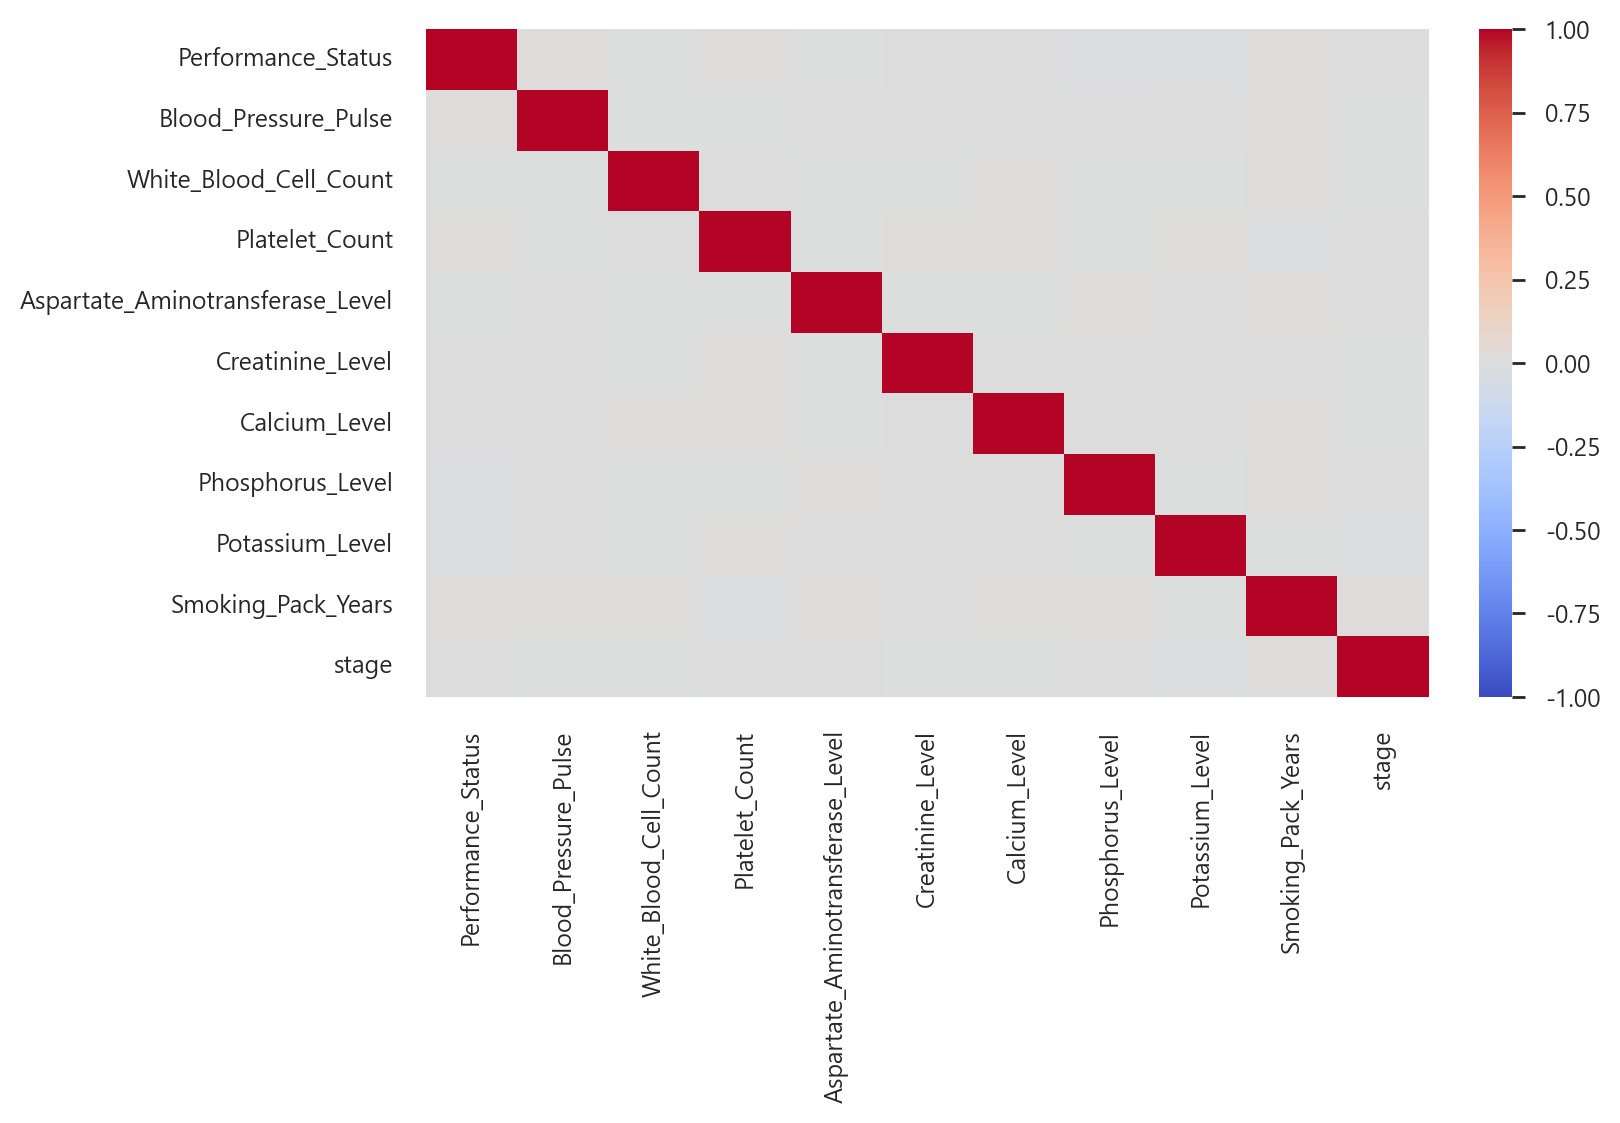

In [828]:
# 각 컬럼별 상관관계 조사하기
fig, ax = plt.subplots()

sns.heatmap(fianl_df.corr(),
            vmax=1,
            vmin=-1,
            cmap="coolwarm",
            ax=ax);

In [829]:
X = fianl_df.drop(columns=["stage"])
y = fianl_df["stage"]

train_x, test_x, train_y, test_y = train_test_split(X,y,
                                                    stratify=fianl_df[fianl_df.columns[-1]])

In [830]:
y.value_counts() # 비율도 얼추 비슷하다.

1    11933
0    11725
Name: stage, dtype: int64

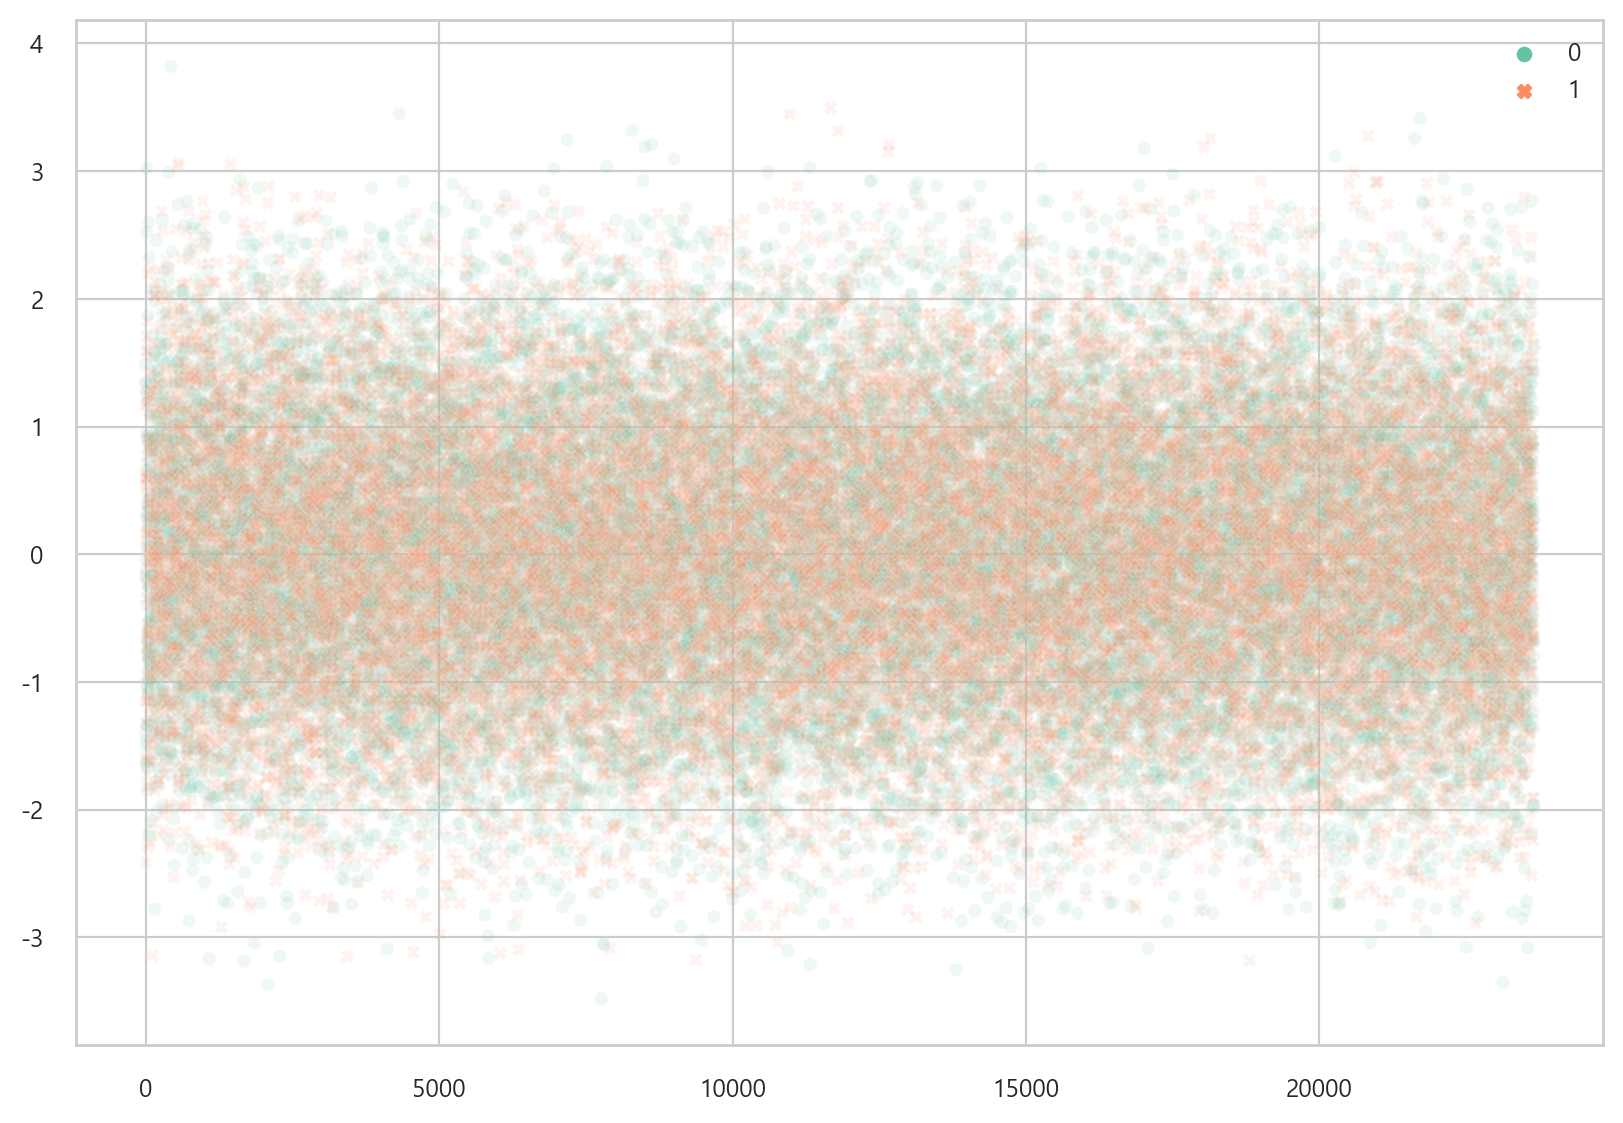

In [831]:
# 이진 분류를 위한 최종 타겟을 stage 를 전기 0 후기 1 로 설정
# 주성분 분석
model_std = StandardScaler()
scaled_X = model_std.fit_transform(X)
scaled_pca = PCA(n_components=2).fit_transform(scaled_X)

fig, ax = plt.subplots()

sns.scatterplot(scaled_pca,
                alpha = 0.1,
                ax=ax);
# (예상) 경계선이 명확한것을 보니 잘 분류할 것 같다.

In [832]:
# 랜더마이즈 함수 정의
def rand_search(params,model_base, iter):
    model_ = RandomizedSearchCV(model_base,
                              params,
                              cv = 5,
                              return_train_score=True,
                              n_iter = iter,
                              n_jobs = -1)

    model_.fit(train_x, train_y)

    print("최상 매개변수:", model_.best_params_)
    print("최고 정확도:", model_.best_score_)
    
    best_model = model_.best_estimator_
    best_pred = model_.predict(test_x)
    print("최고 정확도", accuracy_score(best_pred,test_y))


    return best_model

In [833]:
knn_param = {"n_neighbors" : [5,10,15,20,25,30],}
knn_rans = rand_search(knn_param, KNeighborsClassifier(), 6)

최상 매개변수: {'n_neighbors': 25}
최고 정확도: 0.5076366050045695
최고 정확도 0.49247675401521557


In [834]:
# 교차검증
tree = DecisionTreeClassifier()
cv_pred = cross_validate(tree,train_x,train_y,cv=5)
cv_pred["test_score"].mean()

0.49912672099386174

In [835]:
# 랜덤 포레스트
rf_param = {
"min_samples_leaf" : [20,30,40,50,60],
"max_leaf_nodes" : [2,4,10,20,100,200],
"min_samples_split" : [2,3,4,5,6,10,20,30],
            }
rf_rans = rand_search(rf_param, RandomForestClassifier(oob_score=True), 6)

최상 매개변수: {'min_samples_split': 10, 'min_samples_leaf': 40, 'max_leaf_nodes': 2}
최고 정확도: 0.5068470944544139
최고 정확도 0.5041420118343195


In [836]:
params = {"max_depth" : [1,2,3],
    "learning_rate" : np.arange(0.01, 0.1, 0.005),
    "n_estimators" : np.arange(100, 300, 30)}
xgb = rand_search(rf_param, XGBClassifier(booster = "gbtree",
                                              objective = "binary:logistic"), 6)

최상 매개변수: {'min_samples_split': 20, 'min_samples_leaf': 20, 'max_leaf_nodes': 100}
최고 정확도: 0.5064526965532948
최고 정확도 0.5056635672020288


In [837]:
model_std_train = StandardScaler()
scale_train_x = model_std_train.fit_transform(train_x)
scale_test_x = model_std_train.transform(test_x)

In [838]:
model_multi = Sequential()
model_multi.add(Dense(32,
                       kernel_initializer= 'he_normal',
                       activation = "relu",
                       input_shape = (scaled_X.shape[1], )),)
model_multi.add(Dropout(0.3))
model_multi.add(Dense(16,
                       kernel_initializer= 'he_normal',
                       activation = "relu"))
model_multi.add(Dropout(0.3))
model_multi.add(Dense(1,
                       kernel_initializer= 'he_normal',
                       activation = "sigmoid"))

model_multi.summary()

adam = Adam(learning_rate=0.002)

model_multi.compile(loss = "binary_crossentropy",
                     optimizer=adam,
                     metrics=["accuracy"])

early_s = EarlyStopping(patience=2, # 보통 3 정도 
                        restore_best_weights=True)

model_multi_history = model_multi.fit(scale_train_x, train_y,
                                    epochs=100,
                                    batch_size = 100,
                                    validation_split=0.2,
                                    callbacks=[early_s],
                                    verbose = "auto")

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_110 (Dense)           (None, 32)                352       
                                                                 
 dropout_89 (Dropout)        (None, 32)                0         
                                                                 
 dense_111 (Dense)           (None, 16)                528       
                                                                 
 dropout_90 (Dropout)        (None, 16)                0         
                                                                 
 dense_112 (Dense)           (None, 1)                 17        
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - 

In [839]:
# 정확도 확인
pred_dnn = model_multi.predict(scale_test_x).flatten() > 0.5
pred_knn = knn_rans.predict(test_x)
pred_rf = rf_rans.predict(test_x)
cv_pred
pred_xgb = xgb.predict(test_x)

185/185 [==============================] - 0s 1ms/step


In [840]:
def cf_report(test_y, pred):
    print(classification_report(np.array(test_y),pred))

print("pred_knn")
cf_report(test_y ,pred_knn)
print("pred_rf")
cf_report(test_y ,pred_rf)
print("pred_xgb")
cf_report(test_y ,pred_xgb)
print("pred_dnn")
cf_report(test_y ,pred_dnn)
# xgb is the best

pred_knn
              precision    recall  f1-score   support

           0       0.49      0.48      0.48      2931
           1       0.50      0.51      0.50      2984

    accuracy                           0.49      5915
   macro avg       0.49      0.49      0.49      5915
weighted avg       0.49      0.49      0.49      5915

pred_rf
              precision    recall  f1-score   support

           0       0.50      0.09      0.15      2931
           1       0.50      0.91      0.65      2984

    accuracy                           0.50      5915
   macro avg       0.50      0.50      0.40      5915
weighted avg       0.50      0.50      0.40      5915

pred_xgb
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      2931
           1       0.51      0.51      0.51      2984

    accuracy                           0.51      5915
   macro avg       0.51      0.51      0.51      5915
weighted avg       0.51      0.51      0.51     

185/185 [==============================] - 0s 1ms/step


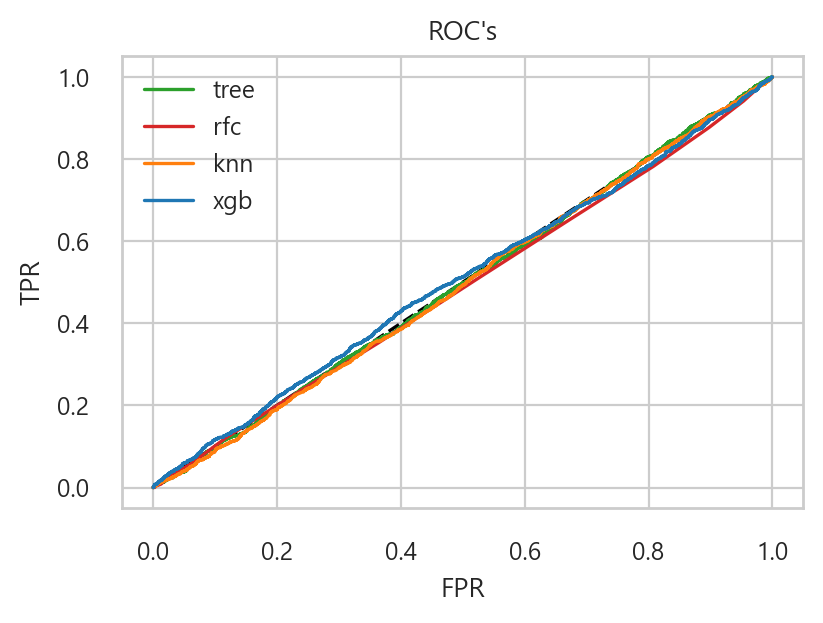

In [841]:
# 정확도_proba 확인
proba_dnn = model_multi.predict(scale_test_x).flatten()
proba_knn = knn_rans.predict_proba(test_x)
proba_rf = rf_rans.predict_proba(test_x)
proba_xgb = xgb.predict_proba(test_x)

tree_fpr, tree_tpr, tree_thr = roc_curve(test_y, proba_dnn)
rfc_fpr, rfc_tpr, rfc_thr = roc_curve(test_y, proba_knn[:,1])
knn_fpr, knn_tpr, knn_thr = roc_curve(test_y, proba_rf[:,1])
xgb_fpr, xgb_tpr, xgb_thr = roc_curve(test_y, proba_xgb[:,1])

fig, ax = plt.subplots(figsize=(4,3))
ax.plot([0,1],[0,1],"k--")
ax.plot(tree_fpr, tree_tpr, label="tree", color = "tab:green")
ax.plot(rfc_fpr, rfc_tpr, label="rfc", color = "tab:red")
ax.plot(knn_fpr, knn_tpr, label="knn", color = "tab:orange")
ax.plot(xgb_fpr, xgb_tpr, label="xgb", color = "tab:blue")
ax.set(xlabel="FPR", ylabel="TPR", title="ROC's")
ax.legend();

In [842]:
print("dnn :", roc_auc_score(test_y, proba_dnn))
print("knn :", roc_auc_score(test_y, proba_knn[:,1]))
print("rf :", roc_auc_score(test_y, proba_rf[:,1]))
print("xgb :", roc_auc_score(test_y, proba_xgb[:,1]))

dnn : 0.4975576553857581
knn : 0.4879417166775058
rf : 0.49391300400727
xgb : 0.5054285885463974


In [843]:
ifl = {}
for a,b in zip(train_x.keys(), rf_rans.feature_importances_):
    ifl[a]=b

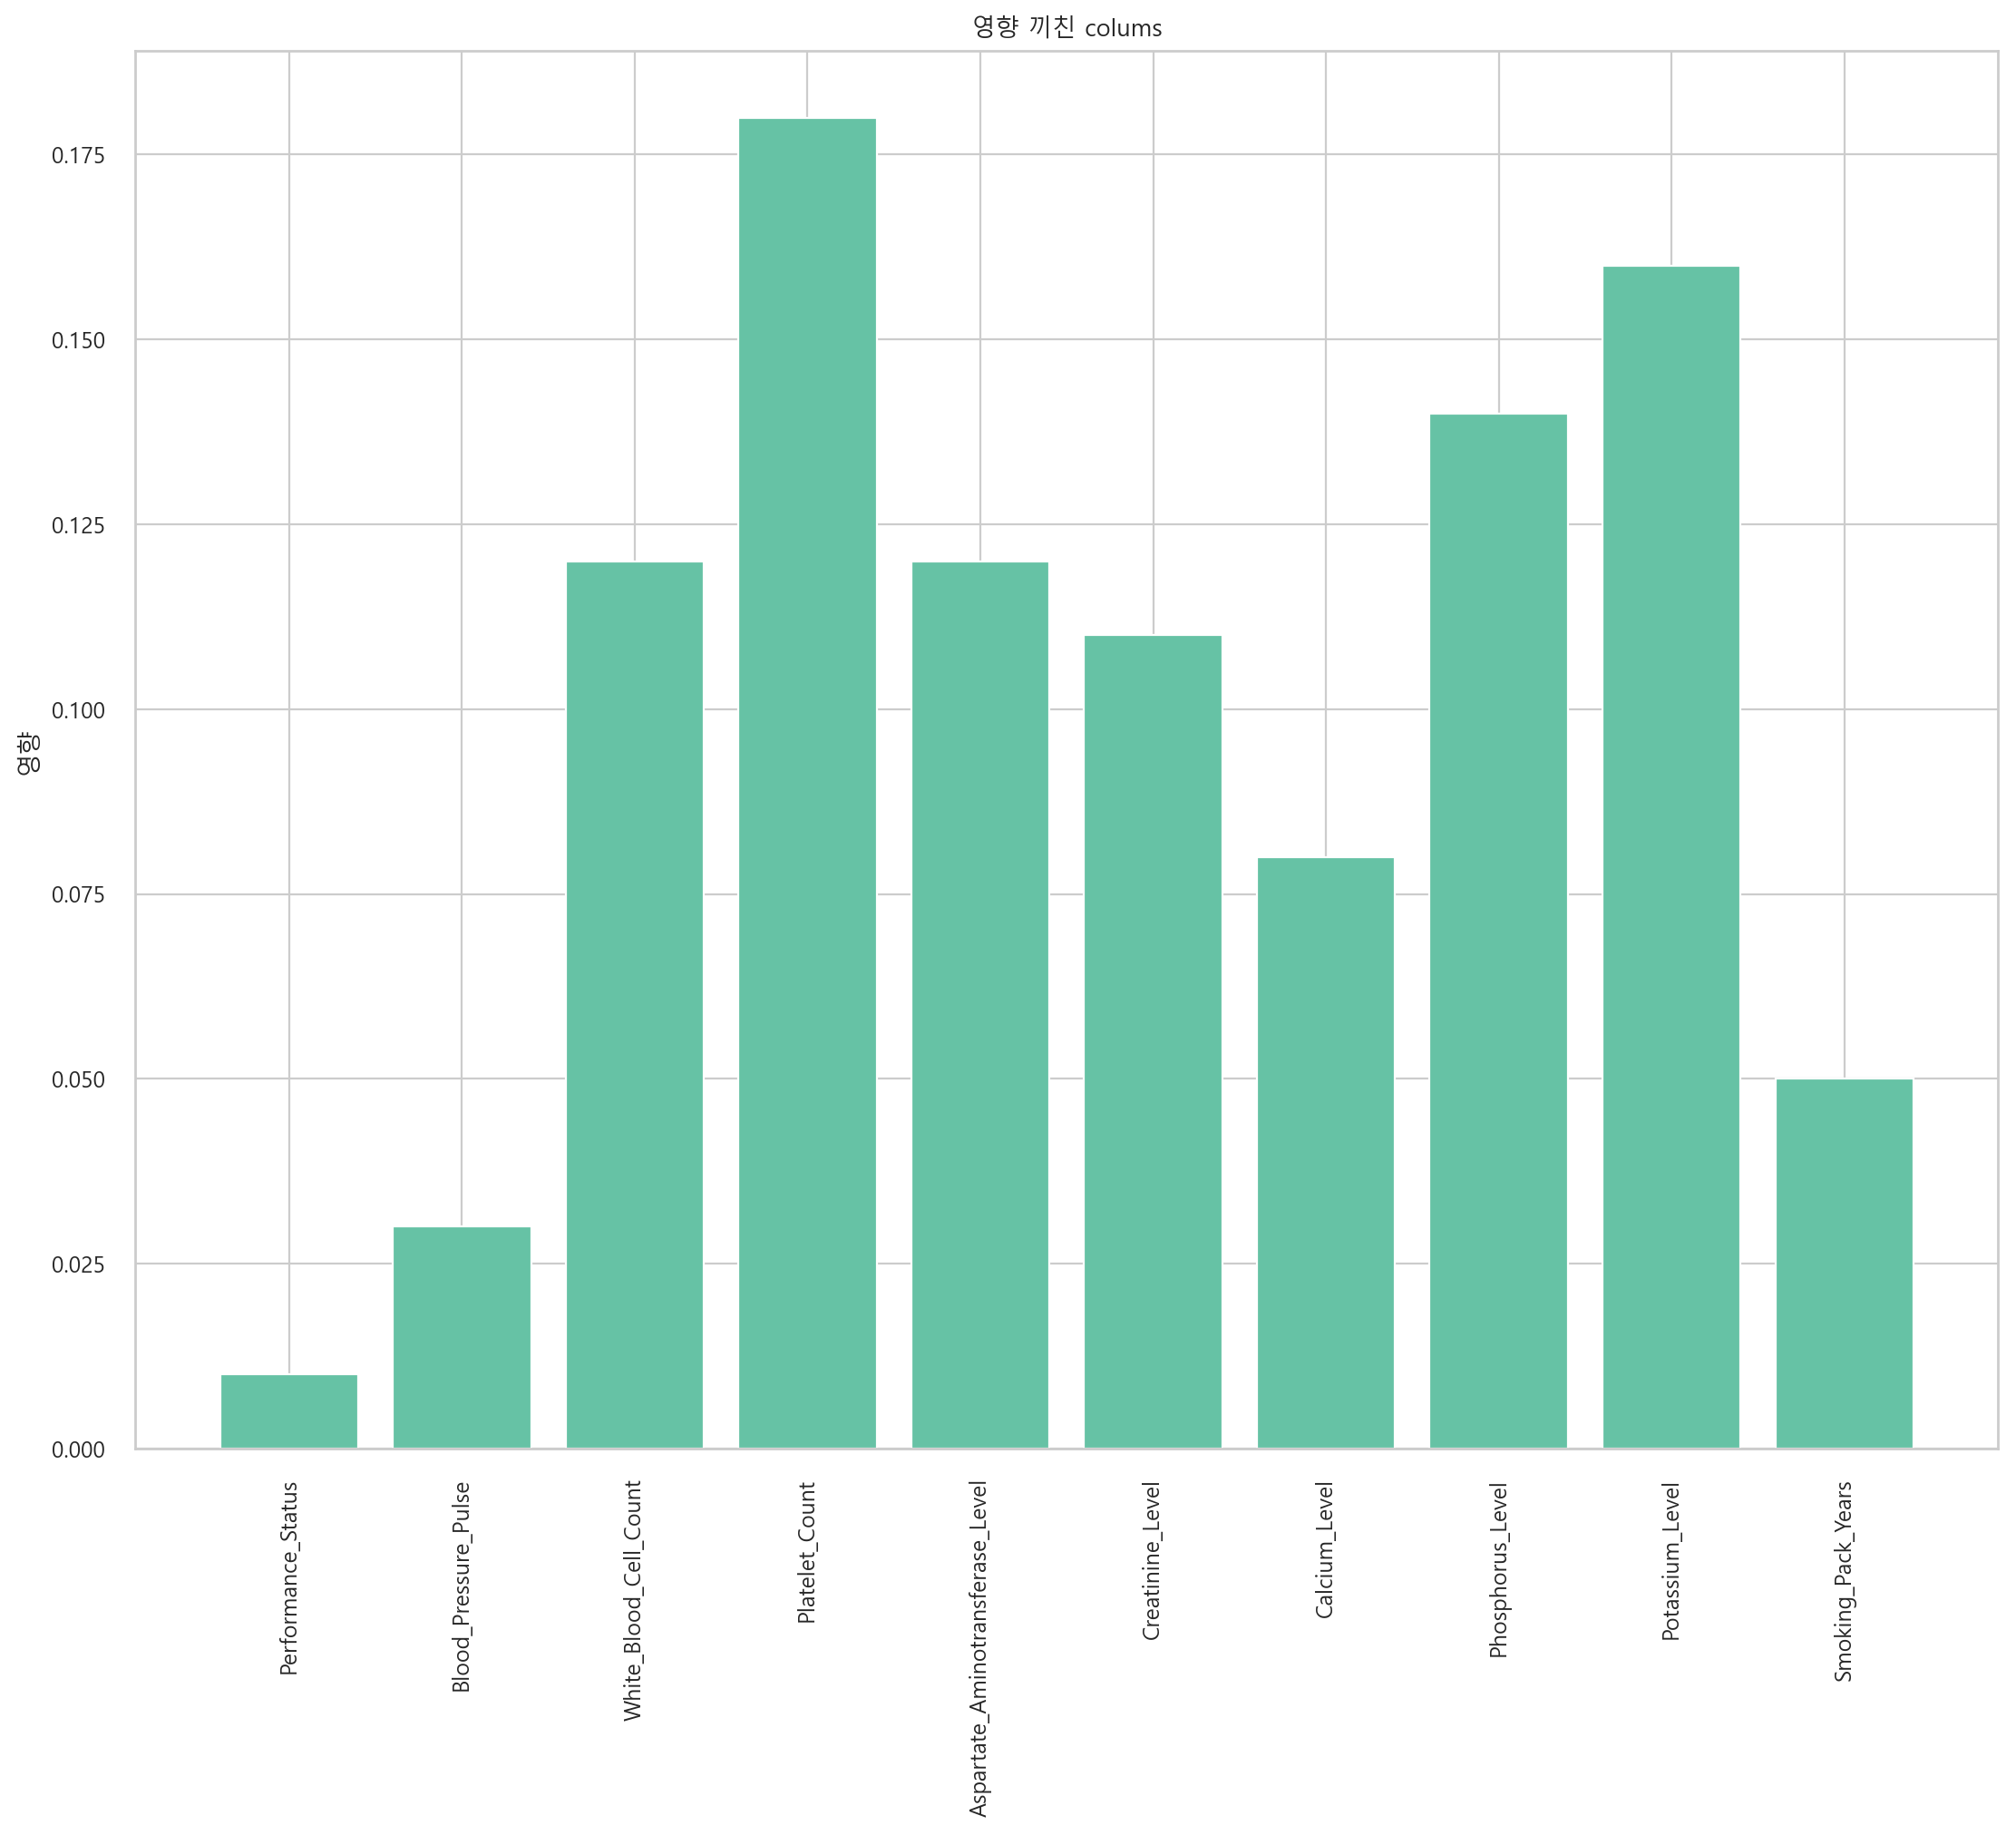

In [844]:
# 가장 높은 랜덤포레스트 영향을 많이 끼친 컬럼

rf_rans.feature_importances_

fig, ax = plt.subplots(figsize=(11,10))
ax.bar(ifl.keys(),
        ifl.values())
ax.set(ylabel="영향", title="영향 끼친 colums")
ax.set_xticklabels(ifl.keys(), rotation=90);

In [825]:
# 0.05 이상만 구해서 돌려보자

final_col = {}
for a,b in zip(train_x.keys(), rf_rans.feature_importances_):
    if b > 0.05:
        final_col[a]=b    

list(final_col.keys())

['Performance_Status',
 'Blood_Pressure_Pulse',
 'White_Blood_Cell_Count',
 'Platelet_Count',
 'Aspartate_Aminotransferase_Level',
 'Creatinine_Level',
 'Calcium_Level',
 'Phosphorus_Level',
 'Potassium_Level',
 'Smoking_Pack_Years']